In [33]:
# take any recorded sound ~/Desktop/closer.wav

# detect onset, return array of onset

# generate spectrograms based on the position of each onset

# evaluate the notes in the spectrogram

# return output

# parse the note-time pair to compare result

In [1]:
import numpy as np
import soundfile as sf
import matplotlib.pyplot as plt
import librosa
import keras

/anaconda3/envs/nd/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/anaconda3/envs/nd/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
filename = "/Users/hkmac/Dropbox/mir2018/musicpygame/august/preparations/wav/0C56DC3C436663F5.wav"
ground_truth = "/Users/hkmac/Dropbox/mir2018/musicpygame/august/preparations/notes/0C56DC3C436663F5.npy"

In [4]:
def load_soundfile(filename):
    audio,sr = sf.read(filename)
    if type(audio[0]) != float or type(audio[0]) != int: 
        # if stereo (expected)
        signal = audio[:,0]  
    else:    
        # if mono (but I have yet to try this out)
        signal = audio[:]
    assert (signal[0] != float or signal[0] != int)
    
    return signal

In [7]:
def rcoeff_(snippet):
    return np.corrcoef(snippet, np.arange(len(snippet)))[0, 1]

rcoeff = np.vectorize(rcoeff_, signature='(n)->()')

def max_to_one(arr):
    '''Scale the maximum of an array to one'''
    return np.divide(arr, np.max(np.absolute(arr)))

def divide_chunks(signal, intervals, snippet_size):
# yield successive n-sized chunks from l.
    for i in range(0, len(signal) - snippet_size, intervals):
        # looping till the end of the array
        yield signal[i:i + snippet_size]

def find_onset(signal):
    signal_cs = np.cumsum(np.absolute(signal))
    signal_cs = np.add(signal_cs, np.random.randn(len(signal_cs)))
    signal_chunk_sum = signal_cs[3456:] - signal_cs[:-3456]
    snippets = np.array(list(divide_chunks(signal_chunk_sum, 32, 3456)))
    signal_rcoeff = rcoeff(snippets)

    onsets = np.multiply(np.where(signal_rcoeff[1:] > 0.8,1,0), 
                         np.where(signal_rcoeff[:-1] < 0.8,1,0))

    plt.figure(figsize=(12,4))
    plt.plot(signal)
    plt.plot(max_to_one(signal_chunk_sum))
    plt.plot(3456+np.arange(0,len(signal_rcoeff)*32,32), signal_rcoeff)
    plt.plot(3456+np.arange(0,len(onsets)*32,32),onsets)
    plt.plot(signal)
    plt.show()
    
    return onsets

<Figure size 864x288 with 0 Axes>

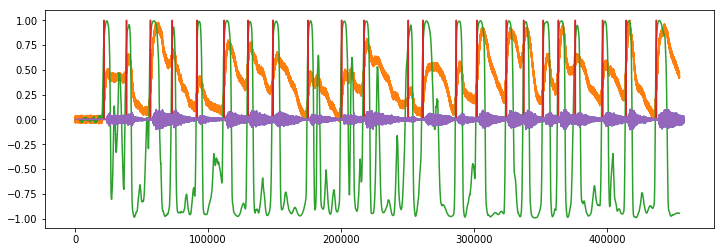

[0 0 0 ... 0 0 0]


In [18]:
plt.figure(figsize=(12,4))
signal = load_soundfile(filename)
onsets = find_onset(signal)

In [9]:
import librosa
def convert_to_CQT(signal_to_map):
    fmin = librosa.core.note_to_hz("B3")
    cqt_array = librosa.cqt(signal_to_map, sr=44100, 
                            hop_length=2**7, bins_per_octave=36, 
                            fmin=fmin, n_bins=108)
    CQT = librosa.magphase(cqt_array)[0][:108,-108:]
    
#     print(np.shape(CQT))
    assert np.shape(CQT)==(108,108)
    return CQT

In [10]:
# spectrogram = generate_spectrogram(signal)
# plt.figure(figsize=(12,4))
# plt.imshow(spectrogram)

In [11]:
np.argwhere(onsets==1)

array([[  567],
       [ 1097],
       [ 1661],
       [ 2173],
       [ 2757],
       [ 3393],
       [ 3954],
       [ 4541],
       [ 5367],
       [ 6154],
       [ 6679],
       [ 7720],
       [ 8073],
       [ 8851],
       [ 9338],
       [10029],
       [10434],
       [10895],
       [11251],
       [11647],
       [12290],
       [12845],
       [13555]])

In [12]:
def setup_classifier(model_path, weight_path):
    yaml_file = open(model_path, 'r')
    loaded = yaml_file.read()
    yaml_file.close()
    classifier = keras.models.model_from_yaml(loaded)
    classifier.load_weights(weight_path)
    return classifier

classifier = setup_classifier(model_path="./weights/model.yaml", 
                              weight_path="./weights/weight-25800-CNN_E_good.hdf5")
# Loading the classifier takes time. 
# It should not be done every time when the program runs.

In [13]:
def predict(data, classifier):
    result = classifier.predict(data)[0].tolist()
    return np.argwhere(np.array(result)>0.99)

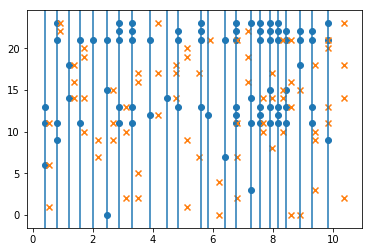

In [32]:
time_note_array_detected = []

for onset in np.argwhere(onsets==1):
    onset = int(onset)

    signal_to_spec = signal[onset*32-27*2**7:onset*32+81*2**7]
#     plt.plot(signal_to_spec)
    spectrogram = convert_to_CQT(signal_to_spec).reshape(1,108,108,1)
    notes = predict(spectrogram, classifier)
    
    time_value = onset*32/44100.
    if notes is not None:
        for note in notes:
            time_note_array_detected.append([time_value,note])

            
np.shape(time_note_array_detected)
times, notes = np.transpose(time_note_array_detected)
for onset in np.argwhere(onsets==1):
    plt.axvline(x=onset*32/44100.)
plt.scatter(times, notes)
times, notes = np.transpose(np.load(ground_truth))
plt.scatter(times/2, notes, marker="x")
plt.show()